# Requirements

In [ ]:
! git clone https://github.com/mohsenfayyaz/DecompX.git
! pip install datasets
! pip install plotly
! pip install -U kaleido
! pip install openpyxl

In [1]:
# MOHSEN
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv()
login(os.environ["HF_TOKEN"])
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 7 HF_HOME: /local1/mohsenfayyaz/.hfcache/


In [ ]:
# ALI
import os
os.chdir('/mounts/Users/cisintern/amodaresi/Projects/Retriever-Contextualization/')
# from dotenv import load_dotenv
from huggingface_hub import login

# load_dotenv()
login(os.environ["HF_TOKEN"])
# print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Load Dataset

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import transformers
from transformers import AutoTokenizer, AutoConfig

from DecompX.src.decompx_utils import DecompXConfig
from DecompX.src.modeling_bert import BertForSequenceClassification, BertModel
from DecompX.src.modeling_roberta import RobertaForSequenceClassification, RobertaModel

pd.set_option('display.max_columns', None)

### NQ
# df_raw = pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/nq/facebook--contriever-msmarco_corpus2681468.pkl")

### RE_DOCRED
df_raw = pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/re-docred/facebook--contriever-msmarco_corpus105925.pkl")
attrs = df_raw.attrs.copy()
df_raw = df_raw.merge(pd.read_pickle("hf://datasets/Retriever-Contextualization/datasets/Re-DocRED/queries_test_validation.pkl"), left_on="query_id", right_on="id")
df_raw.attrs = attrs

df_raw.style.set_properties(**{'background-color': 'black', 'color': 'lawngreen'})

Total: 7170
Total: 7170


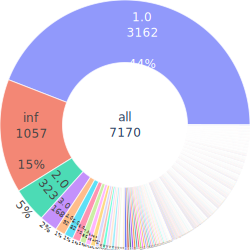

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_score,pred_doc,pred_doc_score,gold_doc_len,pred_doc_len
4980,validation5927,Which sports team is Christian Atsu Twasam a m...,[Christian Atsu],{'Christian Atsu': {'text': 'Christian Atsu Tw...,"{'len': 1000, 'max': 0.6057623624801636, 'min'...",{'Christian Atsu': 0.6057623624801636},"{'Christian Atsu': 0.6057623624801636, 'West V...",{'Christian Atsu': {'text': 'Christian Atsu Tw...,validation5927,Christian Atsu,"[[{'type': 'PER', 'pos': [0, 3], 'name': 'Chri...","[{'r': 'P569', 'h': 0, 't': 1, 'evidence': [0]...","[[Christian, Atsu, Twasam, (, born, 10, Januar...",validation,"{'r': 'P54', 'h': 0, 't': 10, 'evidence': [3]}",8,"[{'type': 'PER', 'pos': [0, 3], 'name': 'Chris...","[{'name': 'Vitesse Arnhem', 'pos': [18, 20], '...","{Atsu, Christian Atsu Twasam}",{Vitesse Arnhem},Christian Atsu Twasam,Vitesse Arnhem,{PER},{ORG},[3],"[[In, 2013, ,, he, was, signed, by, Chelsea, f...",[],"[{'name': 'Vitesse Arnhem', 'pos': [18, 20], '...",P54,member of sports team,Which sports team is Christian Atsu Twasam a m...,0,{},1.0,Christian Atsu Christian Atsu Twasam ( born 10...,0.605762,Christian Atsu Christian Atsu Twasam ( born 10...,0.605762,180,180
3386,test15467,Which administrative territorial entity is New...,[New Haven Harbor],{'New Haven Harbor': {'text': 'New Haven Harbo...,"{'len': 1000, 'max': 0.681281328201294, 'min':...",{'New Haven Harbor': 0.681281328201294},"{'New Haven Harbor': 0.681281328201294, 'Great...",{'New Haven Harbor': {'text': 'New Haven Harbo...,test15467,New Haven Harbor,"[[{'name': 'New Haven Harbor', 'pos': [0, 3], ...","[{'r': 'P706', 'h': 0, 't': 1, 'evidence': [0]...","[[New, Haven, Harbor, is, an, inlet, on, the, ...",test,"{'h': 0, 't': 3, 'r': 'P131', 'evidence': [0]}",64,"[{'name': 'New Haven Harbor', 'pos': [0, 3], '...","[{'name': 'the United States', 'pos': [20, 23]...",{New Haven Harbor},{the United States},New Haven Harbor,the United States,{LOC},{LOC},[0],"[[New, Haven, Harbor, is, an, inlet, on, the, ...","[{'name': 'New Haven Harbor', 'pos': [0, 3], '...","[{'name': 'the United States', 'pos': [20, 23]...",P131,located in the administrative territorial entity,Which administrative territorial entity is New...,0,{},1.0,New Haven Harbor New Haven Harbor is an inlet ...,0.681281,New Haven Harbor New Haven Harbor is an inlet ...,0.681281,268,268
4328,validation3158,Which administrative territorial entity is Reg...,[Regal Mountain],{'Regal Mountain': {'text': 'Regal Mountain is...,"{'len': 1000, 'max': 0.6429650187492371, 'min'...",{'Regal Mountain': 0.6429650187492371},"{'Regal Mountain': 0.6429650187492371, 'Pasayt...",{'Regal Mountain': {'text': 'Regal Mountain is...,validation3158,Regal Mountain,"[[{'name': 'Regal Mountain', 'pos': [0, 2], 's...","[{'r': 'P361', 'h': 0, 't': 1, 'evidence': [0]...","[[Regal, Mountain, is, an, eroded, stratovolca...",validation,"{'h': 0, 't': 5, 'r': 'P131', 'evidence': [0, 1]}",42,"[{'name': 'Regal Mountain', 'pos': [0, 2], 'se...","[{'name': 'the United States', 'pos': [21, 24]...",{Regal Mountain},{the United States},Regal Mountain,the United States,{LOC},{LOC},"[0, 1]","[[Regal, Mountain, is, an, eroded, stratovolca...","[{'name': 'Regal Mountain', 'pos': [0, 2], 'se...","[{'name': 'the United States', 'pos': [21, 24]...",P131,located in the administrative territorial entity,Which administrative territorial entity is Reg...,0,{},1.0,Regal Mountain Regal Mountain is an eroded str...,0.642965,Regal Mountain Regal Mountain is an eroded str...,0.642965,203,203
3391,test15489,What is the o

In [3]:
### df filtering
import plotly.express as px

def find_index(l, idx, not_found_value=np.inf):
    try:
        return l.index(idx)
    except:
        return not_found_value

### FILTER MULTI GOLD DOCS
print("Total:", len(df_raw))
df = df_raw.loc[df_raw["gold_docs"].str.len() == 1, :].copy()
print("Total:", len(df))
# df.drop_duplicates(subset=["query"], keep="first", inplace=True)
# print("Total:", len(df))

### COMPUTE HIT RANK
df["hit_rank"] = df.apply(lambda row: min([find_index(list(row["scores_1000"].keys()), doc_id) + 1 for doc_id in row["gold_docs"]]), axis=1)
# df["hit_rank"].hist(figsize=(8, 4), bins=50)

dfc = df.copy(); dfc["hit_rank"] = dfc["hit_rank"].astype(str);
fig = px.sunburst(dfc, path=[px.Constant("all"), 'hit_rank'], width=250, height=250)
fig.update_traces(textinfo='label+percent entry+value')
fig.update_layout(margin={'t':0,'l':0,'b':0,'r':0})
fig.show("svg")

### Prepare Docs (title+text)
df["gold_doc"] = df["gold_docs_text"].apply(lambda x: list(x.items())[0][1])
df["gold_doc"] = df["gold_doc"].apply(lambda x: x["title"] + " " + x["text"])
df["gold_doc_score"] = df["scores_gold"].apply(lambda x: list(x.items())[0][1])
df["pred_doc"] = df["predicted_docs_text_10"].apply(lambda x: list(x.items())[0][1])
df["pred_doc"] = df["pred_doc"].apply(lambda x: x["title"] + " " + x["text"])
df["pred_doc_score"] = df["scores_1000"].apply(lambda x: list(x.items())[0][1])

df["gold_doc_len"] = df["gold_doc"].str.split().apply(len)
df["pred_doc_len"] = df["pred_doc"].str.split().apply(len)


df.sort_values("hit_rank")

In [ ]:
df

# DecompX

In [4]:
DATASET = df.attrs["dataset"]
MODEL = df.attrs["model"]  # 'facebook/contriever-msmarco'  # Only BERT or RoBERTa
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CONFIGS = {
    "DecompX":
        DecompXConfig(
            include_biases=True,
            bias_decomp_type="absdot",
            include_LN1=True,
            include_FFN=True,
            FFN_approx_type="GeLU_ZO",
            include_LN2=True,
            aggregation="vector",
            include_classifier_w_pooler=True,
            tanh_approx_type="ZO",
            output_all_layers=True,
            output_attention=None,
            output_res1=None,
            output_LN1=None,
            output_FFN=None,
            output_res2=None,
            output_encoder=None,
            output_aggregated="vector",  # Changed
            output_pooler="norm",
            output_classifier=True,
        ),
}

def load_model_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model_config = AutoConfig.from_pretrained(model_name)
    if type(model_config) is transformers.models.roberta.configuration_roberta.RobertaConfig:
        model = RobertaModel.from_pretrained(model_name)
    elif type(model_config) is transformers.models.bert.configuration_bert.BertConfig:
        model = BertModel.from_pretrained(model_name)
    else:
        raise Exception(f"Not implemented model: {model_name}")
    model.to(DEVICE)
    return model, tokenizer

model, tokenizer = load_model_tokenizer(MODEL)

/local1/mohsenfayyaz/anaconda3/envs/beir-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [5]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib

def print_importance(importance, tokenized_text, discrete=False, prefix=""):
    """
    importance: (sent_len)
    """
    assert len(importance) == len(tokenized_text)
    importance = importance / np.abs(importance).max() / 1.0  # Normalize
    if discrete:
        importance = np.argsort(np.argsort(importance)) / len(importance) / 1.6

    html = "<pre style='line-height: 28px; display: flex; flex-flow: row wrap;'>"+prefix
    for i in range(len(tokenized_text)):
        # if importance[i] > 0:
        #     rgba = plt.get_cmap('Reds')(importance[i] * .7)   # Wistia
        # else:
        #     rgba = plt.get_cmap('Greens')(np.abs(importance[i]) + .5)   # Wistia
        rgba = plt.get_cmap('coolwarm')((importance[i] + 1) / 2)
        text_color = "color: rgba(255, 255, 255, 1.0); " if np.abs(importance[i]) > 1 else "color: rgba(10, 10, 10, 1.0); "
        color = f"background-color: rgba({rgba[0]*255}, {rgba[1]*255}, {rgba[2]*255}, {rgba[3]}); " + text_color
        html += (f"<div style='"
                 f"{color}"
                 f"border-radius: 5px; padding: 2px; margin: 1px;"
                 f"font-weight: {int(800)};"
                 "width: fit-content; display: flex;"
                 "'>")
        html += tokenized_text[i].replace('<', "[").replace(">", "]")
        html += "</div> "
        if tokenized_text[i] in ["hypothesis,", "hold.", '"contradiction"']:
            html += '<br>'
    return html

def html_wrapper(htmls, desc="text", legend="?"):
    html = ""
    head = """
    <head>
    <style>
        @media print {
            -webkit-print-color-adjust: exact;
        }
        fieldset {
            max-width: 1000px; padding: 8px; border-radius: 20px; border: 3px solid rgb(15, 200, 200); background: white; color: black;
        }
        legend {
            margin-left: 10px; padding: 7px; padding-left: 20px; padding-right: 20px; border: 2px solid rgb(15, 200, 200);
            border-radius: 20px; background: white;
            /*font-family: Arial !important;*/
            font-weight: 600;
        }
        table tr td {
            white-space: nowrap; padding: 5px; color: black;
        }
    </style>
    </head>
    """
    html += head
    html += f"""
        <fieldset>
            <legend>{legend}</legend>
            <table style='width: 1000px; font-weight: 600;'>
            """
    for i in range(len(htmls)):
        html += """
        <tr>
        """
        html += f"<td style='text-align: center; width: 100px;'>{desc}:</td><td>"
        html += htmls[i]
        html += "</td></tr>"
    html += "</table>"
    return html

/local1/mohsenfayyaz/anaconda3/envs/beir-env/lib/python3.11/site-packages/transformers/modeling_utils.py:1101: FutureWarning:

The `device` argument is deprecated and will be removed in v5 of Transformers.



torch.Size([1, 10, 768])
torch.Size([1, 152, 768])
torch.Size([1, 260, 768])


Query:,[CLS] who performed the church of hot addiction ? [SEP]


Gold Doc:


Pred Doc:


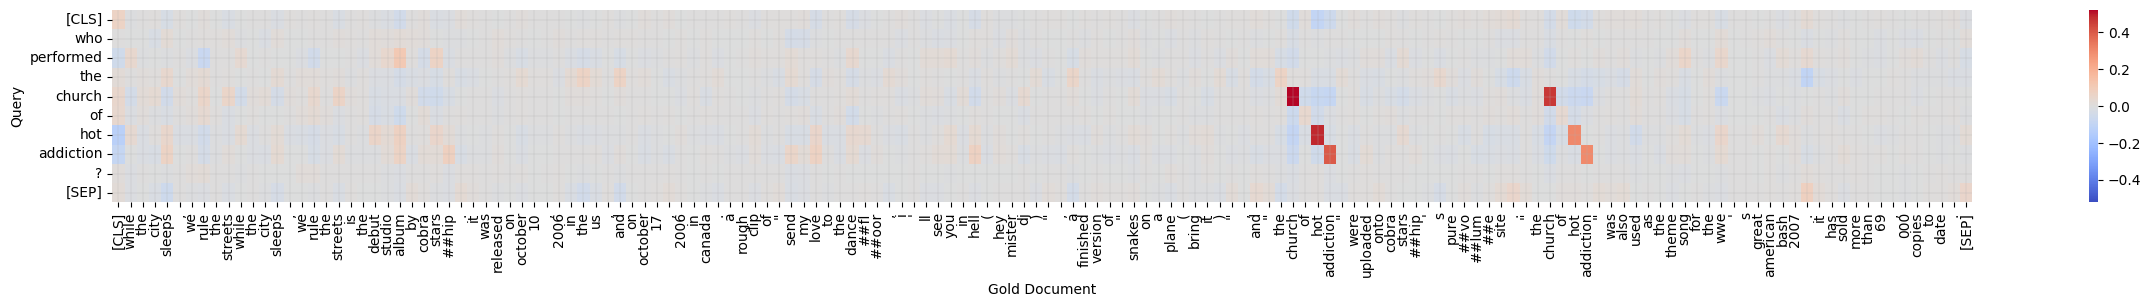

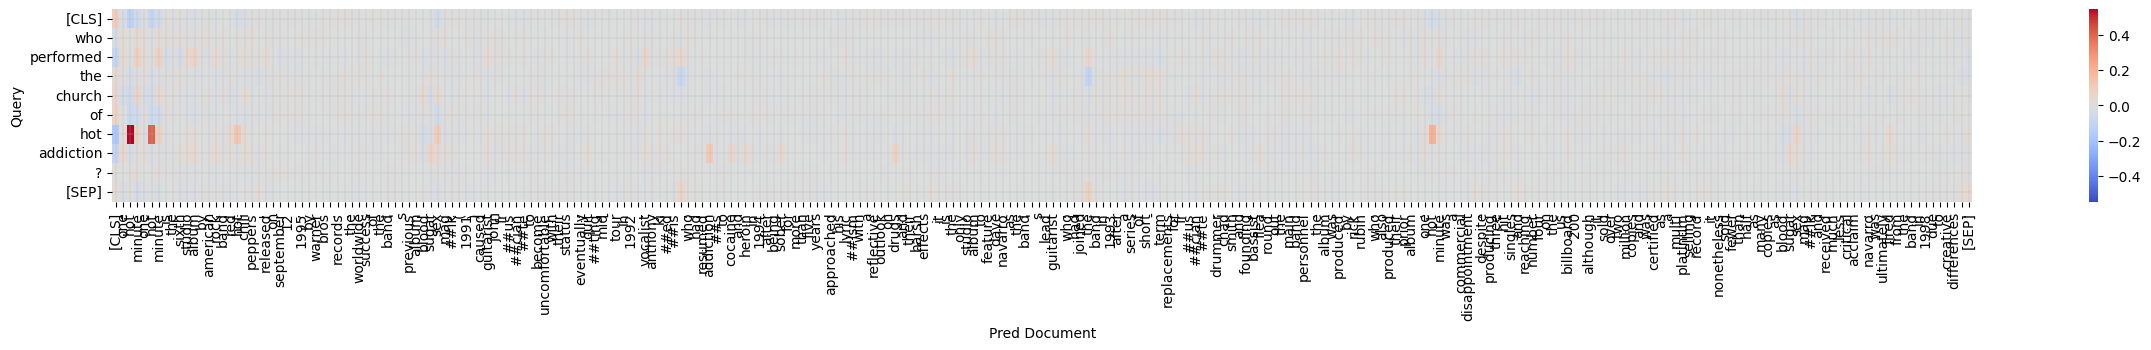

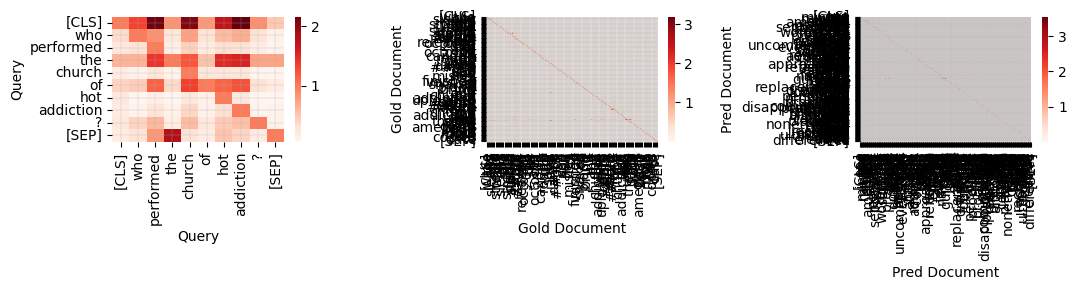

In [14]:
def run_decompx(text):
    inputs = tokenizer([text], padding=True, truncation=True, return_tensors='pt')
    input_ids = inputs["input_ids"]
    inputs.to(model.device)
    with torch.no_grad():
        last_hidden_states, pooler_output, hidden_states, decompx_last_layer_outputs, decompx_all_layers_outputs = model(
            **inputs,
            output_attentions=False,
            return_dict=False,
            output_hidden_states=True,
            decompx_config=CONFIGS["DecompX"]
        )
        ### decompx_last_layer_outputs.aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim] ###
        ### last_hidden_states ~ [1, 70, 768] ~ [batch, seq_len, emb_dim]
        print(last_hidden_states.shape)  # 
        mean_pooled = last_hidden_states[0].mean(dim=0)
        decompx_last_layer_mean = decompx_last_layer_outputs.aggregated[0][0].mean(dim=(0))  # Mean over DecompX similar to the retriever [seq_len, emb_dim]
        tokens_dot_scores = torch.einsum("ij,j->i", decompx_last_layer_mean, mean_pooled)  # [seq_len]
        ranking = torch.argsort(tokens_dot_scores, descending=True).cpu().numpy()
    return {
        "tokens": tokenizer.convert_ids_to_tokens(input_ids[0]),  # [seq_len]
        "tokens_dot_scores": tokens_dot_scores.cpu(),  # [seq_len]  (Dot score with mean)
        "decompx_last_layer_outputs": decompx_last_layer_outputs,  # .aggregated ~ 1 * [1, 70, 70, 768] ~ layer * [batch, seq, seq, emb_dim]
        "decompx_last_layer_mean": decompx_last_layer_mean.cpu(),  # [seq_len, emb_dim]
    }

def plot_demo(idx):
    ### RUN DECOMPX ON QUERY AND DOC
    query = run_decompx(df.loc[idx]["query"])
    gold_doc = run_decompx(df.loc[idx]["gold_doc"])
    pred_doc = run_decompx(df.loc[idx]["pred_doc"])
    head_entity = df.loc[idx]['head_entity_longest_name'] if 'head_entity_longest_name' in df.columns else '?'
    tail_entity = df.loc[idx]['tail_entity_longest_name'] if 'tail_entity_longest_name' in df.columns else '?'
    relation = df.loc[idx]['relation_name'] if 'relation_name' in df.columns else '?'
    split = df.loc[idx]['split'] if 'split' in df.columns else '?'
    
    ### PLOT MEAN DOT IMPORTANCE
    htmls = [print_importance(query["tokens_dot_scores"], query["tokens"])]
    final_html = html_wrapper(htmls, "Query", f"{DATASET}, {MODEL}, idx={idx}, (head={head_entity}, relation={relation}, tail={tail_entity})")
    display(HTML(final_html))
    htmls = [print_importance(gold_doc["tokens_dot_scores"], gold_doc["tokens"])]
    final_html = html_wrapper(htmls, "Gold Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['gold_doc_score']}, hit_rank={df.loc[idx]['hit_rank']}")
    display(HTML(final_html))
    htmls = [print_importance(pred_doc["tokens_dot_scores"], pred_doc["tokens"])]
    final_html = html_wrapper(htmls, "Pred Doc", f"{DATASET}, {MODEL}, idx={idx}, score={df.loc[idx]['pred_doc_score']}")
    display(HTML(final_html))
    
    ### PLOT CROSS DOT IMPORTANCE
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_qd_heatmap(query_tokens, query_decomposed, doc_tokens, doc_decomposed, xlabel="Doc", ylabel="Query"):
        with torch.no_grad():
            qd_scores = torch.einsum("id,jd->ij", query_decomposed, doc_decomposed).cpu().numpy()
        plt.figure(figsize=(30, 2.5))  # 30 for debug 15 for aesthetics
        heatmap(qd_scores, cmap=plt.get_cmap('coolwarm'), vmin=-np.max(np.abs(qd_scores)), vmax=np.max(np.abs(qd_scores)))
        plt.xticks(np.arange(len(doc_tokens))+0.5, doc_tokens, rotation='vertical')
        plt.yticks(np.arange(len(query_tokens))+0.5, query_tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.show()
    
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], gold_doc["tokens"], gold_doc["decompx_last_layer_mean"], "Gold Document")
    plot_qd_heatmap(query["tokens"], query["decompx_last_layer_mean"], pred_doc["tokens"], pred_doc["decompx_last_layer_mean"], "Pred Document")
    
    
    ### PLOT SELF DECOMPX BLOCKS
    from seaborn import heatmap
    import matplotlib.pyplot as plt
    
    def plot_decompx_heatmap(tokens, decompx_last_layer_outputs, label="?"):
        norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
        heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)), cmap=plt.get_cmap('Reds'))
        plt.xticks(np.arange(len(tokens))+0.5, tokens, rotation='vertical')
        plt.yticks(np.arange(len(tokens))+0.5, tokens, rotation='horizontal')
        plt.grid("on", linewidth=0.2); plt.xlabel(label); plt.ylabel(label)
    
    plt.figure(figsize=(11, 3))
    plt.subplot(1, 3, 1); plot_decompx_heatmap(query["tokens"], query["decompx_last_layer_outputs"], "Query")
    plt.subplot(1, 3, 2); plot_decompx_heatmap(gold_doc["tokens"], gold_doc["decompx_last_layer_outputs"], "Gold Document")
    plt.subplot(1, 3, 3); plot_decompx_heatmap(pred_doc["tokens"], pred_doc["decompx_last_layer_outputs"], "Pred Document")
    plt.tight_layout()

plot_demo(idx=1526)  # 329

# Playground

In [8]:
rank_ranges = [
    # [2, 5], [6, 20], 
    [21, np.inf]
]

df_err = None
for rank_range in rank_ranges:
    dfc = df.copy()
    dfc = dfc[(dfc["hit_rank"] >= rank_range[0]) & (dfc["hit_rank"] <= rank_range[1])].sample(1000, random_state=0).sort_index().sort_values("hit_rank")
    df_err = dfc.copy() if df_err is None else pd.concat([df_err, dfc.copy()])
# df_err[["query_id", "query", "gold_docs", "hit_rank", "gold_doc", "gold_doc_score", "pred_doc", "pred_doc_score", "gold_doc_len", "pred_doc_len"]].to_excel("temp.xlsx")
df_err.sort_values("gold_doc", key=lambda x: x.str.len())

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_score,pred_doc,pred_doc_score,gold_doc_len,pred_doc_len
1526,test7309,Who performed The Church of Hot Addiction?,"[While the City Sleeps, We Rule the Streets]","{'While the City Sleeps, We Rule the Streets':...","{'len': 1000, 'max': 0.4978748559951782, 'min'...","{'While the City Sleeps, We Rule the Streets':...","{'One Hot Minute': 0.4978748559951782, 'Three ...",{'One Hot Minute': {'text': 'One Hot Minute is...,test7309,"While the City Sleeps, We Rule the Streets","[[{'type': 'MISC', 'pos': [0, 9], 'name': 'Whi...","[{'r': 'P175', 'h': 0, 't': 1, 'evidence': [0]...","[[While, the, City, Sleeps, ,, We, Rule, the, ...",test,"{'r': 'P175', 'h': 7, 't': 1, 'evidence': [2]}",4,"[{'type': 'MISC', 'pos': [42, 47], 'name': 'Th...","[{'name': 'Cobra Starship', 'pos': [15, 17], '...",{The Church of Hot Addiction},{Cobra Starship},The Church of Hot Addiction,Cobra Starship,{MISC},{ORG},[2],"[[A, rough, clip, of, "", Send, My, Love, to, t...","[{'type': 'MISC', 'pos': [42, 47], 'name': 'Th...","[{'type': 'ORG', 'pos': [51, 53], 'name': 'Cob...",P175,performer,Who performed The Church of Hot Addiction?,0,{},31.0,"While the City Sleeps, We Rule the Streets Whi...",0.414923,One Hot Minute One Hot Minute is the sixth stu...,0.497875,137,242
1696,test7900,When was Conduct Zero published?,[Joh Keun-shik],{'Joh Keun-shik': {'text': 'Joh Keun - shik ( ...,"{'len': 1000, 'max': 0.5961207151412964, 'min'...",{'Joh Keun-shik': 0.3900643587112427},"{'Zero for Conduct': 0.5961207151412964, 'Wiki...",{'Zero for Conduct': {'text': 'Zero for Conduc...,test7900,Joh Keun-shik,"[[{'name': 'Joh Keun-shik', 'pos': [0, 4], 'se...","[{'r': 'P27', 'h': 0, 't': 2, 'evidence': [0]}...","[[Joh, Keun, -, shik, (, born, 1968, ), is, a,...",test,"{'r': 'P577', 'h': 3, 't': 4, 'evidence': [1]}",7,"[{'pos': [3, 5], 'type': 'MISC', 'sent_id': 1,...","[{'pos': [6, 7], 'type': 'TIME', 'sent_id': 1,...",{Conduct Zero},{2002},Conduct Zero,2002,{MISC},{TIME},[1],"[[Joh, debuted, with, Conduct, Zero, (, 2002, ...","[{'pos': [3, 5], 'type': 'MISC', 'sent_id': 1,...","[{'pos': [6, 7], 'type': 'TIME', 'sent_id': 1,...",P577,publication date,When was Conduct Zero published?,0,{},137.0,Joh Keun-shik Joh Keun - shik ( born 1968 ) is...,0.390064,Zero for Conduct Zero for Conduct ( ) is a 193...,0.596121,133,182
1701,test7907,What is 15th Chunsa Film Art Awards an instanc...,[Joh Keun-shik],{'Joh Keun-shik': {'text': 'Joh Keun - shik ( ...,"{'len': 1000, 'max': 0.5035775899887085, 'min'...",{'Joh Keun-shik': 0.3526982367038727},{'Academy Award for Best Picture': 0.503577589...,{'Academy Award for Best Picture': {'text': 'T...,test7907,Joh Keun-shik,"[[{'name': 'Joh Keun-shik', 'pos': [0, 4], 'se...","[{'r': 'P27', 'h': 0, 't': 2, 'evidence': [0]}...","[[Joh, Keun, -, shik, (, born, 1968, ), is, a,...",test,"{'r': 'P31', 'h': 11, 't': 7, 'evidence': [2]}",14,"[{'sent_id': 2, 'type': 'MISC', 'pos': [40, 45...","[{'pos': [22, 24], 'type': 'MISC', 'sent_id': ...",{15th Chunsa Film Art Awards},{Best Film},15th Chunsa Film Art Awards,Best Film,{MISC},{MISC},[2],"[[His, second, feature, Once, in, a, Summer, (...","[{'sent_id': 2, 'type': 'MISC', 'pos': [40, 45...","[{'pos': [22, 24], 'type': 'MISC', 'sent_id': ...",P31,instance of,What is 15th Chunsa Film Art Awards an instanc...,0,{},437.0,Joh Keun-shik Joh Keun - shik ( born 1968 ) is...,0.352698,Academy Award for Best Picture The Academy Awa...,0.503578,133,141
1698,test7902,When was Once in a Summer published?,[Joh Keun-shik],{'Joh Keun-shik': {'text': 'Joh K

/tmp/ipykernel_149579/311792779.py:13: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



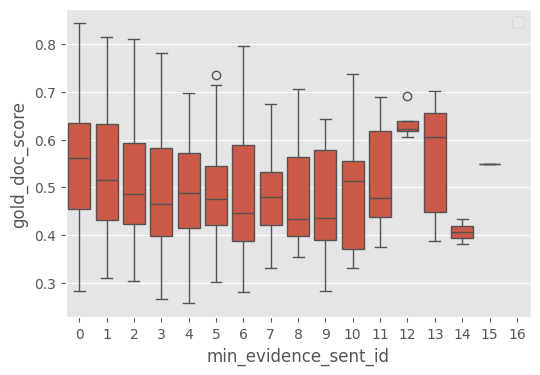

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_score,pred_doc,pred_doc_score,gold_doc_len,pred_doc_len,min_evidence,first_head_entity_type,first_tail_entity_type
0,test0,When was Loud Tour published?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.5781064033508301, 'min'...",{'Loud Tour': 0.5781064033508301},"{'Loud Tour': 0.5781064033508301, 'Images and ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...","{Loud Tour, Loud}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in,...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': ...",P577,publication date,When was Loud Tour published?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,0.578106,Loud Tour The Loud Tour was the fourth overall...,0.578106,142,142,1,MISC,TIME
1,test1,Who performed Loud Tour?,[Loud Tour],{'Loud Tour': {'text': 'The Loud Tour was the ...,"{'len': 1000, 'max': 0.6464771032333374, 'min'...",{'Loud Tour': 0.6464771032333374},"{'Loud Tour': 0.6464771032333374, 'Live &amp; ...",{'Loud Tour': {'text': 'The Loud Tour was the ...,test1,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id':...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]...","[[The, Loud, Tour, was, the, fourth, overall, ...",test,"{'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}",1,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [3, 4], 'sent_id':...","{Loud Tour, Loud}",{Rihanna},Loud Tour,Rihanna,{MISC},{PER},"[0, 1]","[[The, Loud, Tour, was, the, fourth, overall, ...","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': ...","[{'name': 'Rihanna', 'pos': [18, 19], 'sent_id...",P175,performer,Who performed Loud Tour?,0,{},1.0,Loud Tour The Loud Tour was the fourth overall...,0.646477,Loud Tour The Loud Tour was the fourth overall...,0.646477,142,142,0,MISC,PER


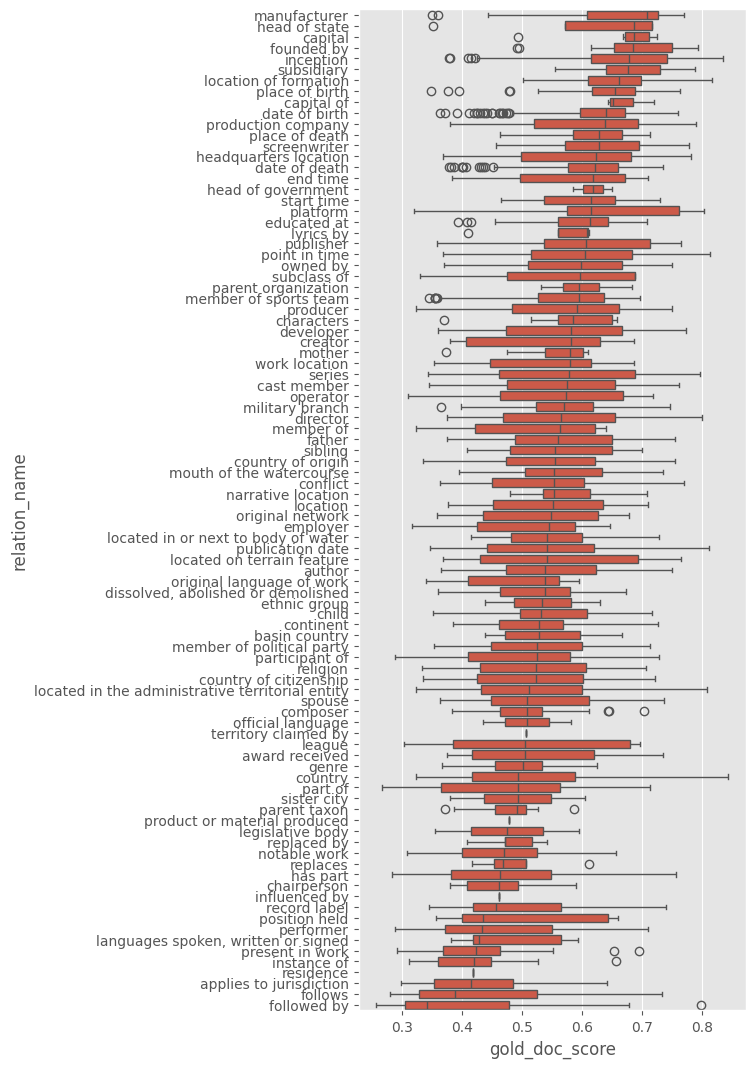

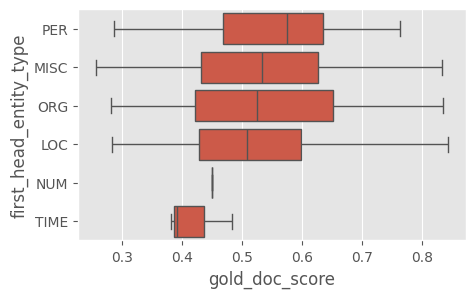

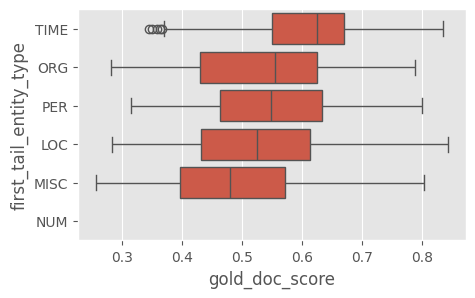

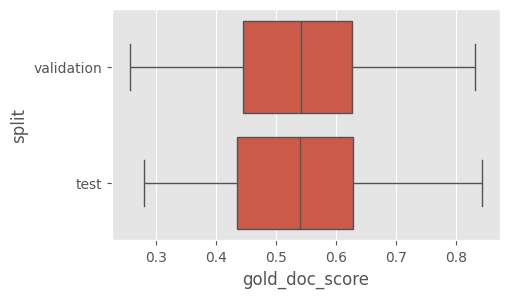

In [54]:
### DOC POS STATS
import seaborn as sns
plt.style.use("ggplot")

### SCATTER PLOT
dfc = df.copy()
dfc["min_evidence"] = df["evidence_sent_ids"].apply(min)
plt.figure(figsize=(6, 4))
sns.boxplot(data=dfc, x="min_evidence", y="gold_doc_score")
# dfc.boxplot(column=['min_evidence', 'gold_doc_score'])
# plt.scatter(dfc["min_evidence"], dfc["gold_doc_score"], color="orange", label="Gold Doc", alpha=0.5, s=1)
# plt.scatter(dfc2["hit_rank"], dfc2["pred_doc_len"], color="blue", label="Pred Doc", alpha=0.5, s=1)
plt.legend(); plt.xlabel("min_evidence_sent_id"); plt.ylabel("gold_doc_score")
plt.show()


# sns.boxplot(data=dfc.sort_values("gold_doc_score"), y="relation_name", x="gold_doc_score")
# plt.show()

def boxplot_ordered(df2, x, y, rotate=False):
    grouped = dfc.loc[:,[x, y]].groupby([x]).median().sort_values(by=y, ascending=False)
    if not rotate:
        sns.boxplot(x=dfc[x], y=dfc[y], order=grouped.index)
    else:
        sns.boxplot(x=dfc[y], y=dfc[x], order=grouped.index)

plt.figure(figsize=(5, 13))
boxplot_ordered(dfc, 'relation_name', 'gold_doc_score', rotate=True)
# grouped = dfc.loc[:,['relation_name', 'gold_doc_score']].groupby(['relation_name']).median().sort_values(by='gold_doc_score', ascending=False)
# sns.boxplot(x=dfc.gold_doc_score, y=dfc.relation_name, order=grouped.index)

plt.figure(figsize=(5, 3))
dfc['first_head_entity_type'] = dfc['head_entity_types'].apply(lambda x: list(x)[0])
boxplot_ordered(dfc, 'first_head_entity_type', 'gold_doc_score', rotate=True)

plt.figure(figsize=(5, 3))
dfc['first_tail_entity_type'] = dfc['tail_entity_types'].apply(lambda x: list(x)[0])
boxplot_ordered(dfc, 'first_tail_entity_type', 'gold_doc_score', rotate=True)


plt.figure(figsize=(5, 3))
boxplot_ordered(dfc, 'split', 'gold_doc_score', rotate=True)

dfc.head(2)

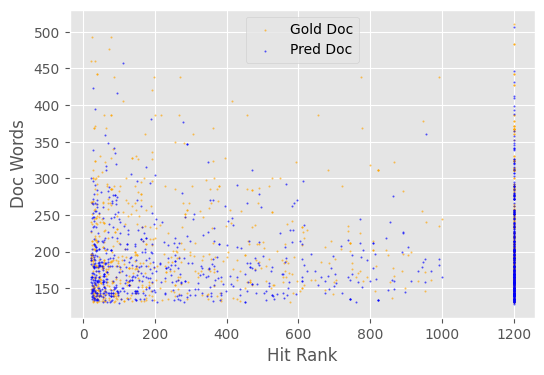

<Figure size 600x400 with 0 Axes>

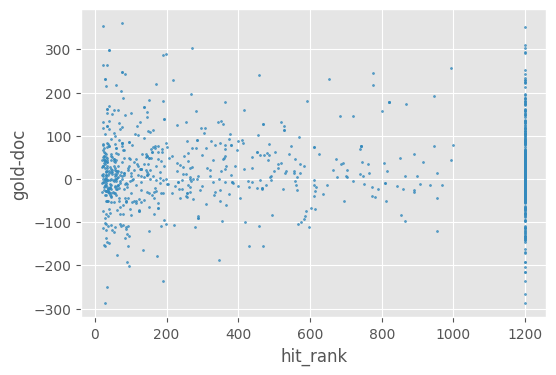

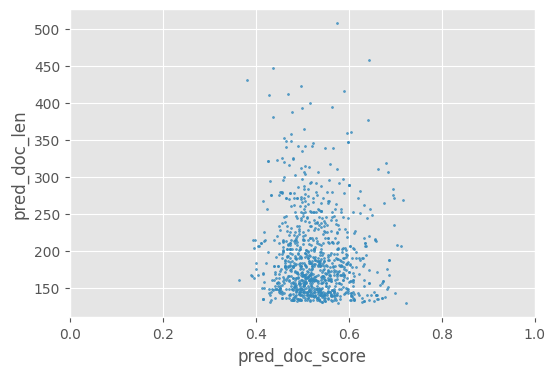

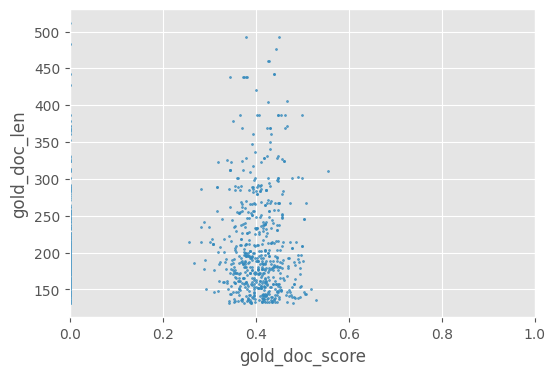

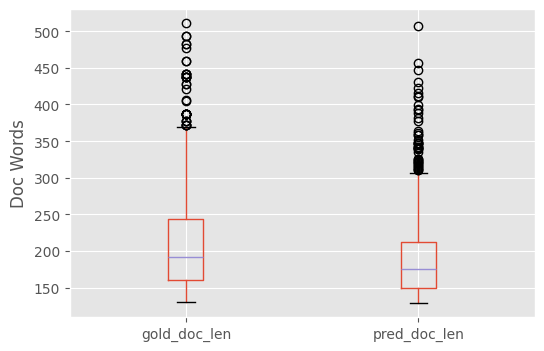

In [16]:
### DOC LEN STATS
plt.style.use("ggplot")

### SCATTER PLOT
dfc2 = dfc.copy(); dfc2.loc[dfc2["hit_rank"] > 1e5, "hit_rank"] = 1200;
plt.figure(figsize=(6, 4))
plt.scatter(dfc2["hit_rank"], dfc2["gold_doc_len"], color="orange", label="Gold Doc", alpha=0.5, s=1)
plt.scatter(dfc2["hit_rank"], dfc2["pred_doc_len"], color="blue", label="Pred Doc", alpha=0.5, s=1)
plt.legend(); plt.xlabel("Hit Rank"); plt.ylabel("Doc Words")
plt.show()

### LEN DIFF PLOT
dfc2["gold-doc"] = dfc2.apply(lambda row: row["gold_doc_len"] - row["pred_doc_len"], axis=1)
dfc2 = dfc2.fillna(0)
plt.figure(figsize=(6, 4))
dfc2.plot.scatter(x="hit_rank", y="gold-doc", alpha=0.8, s=2, figsize=(6, 4))
# plt.scatter(dfc2["hit_rank"], dfc2["gold-doc"], color="orange", label="Gold Doc", alpha=0.5, s=1)
# plt.legend(); plt.xlabel("Hit Rank"); plt.ylabel("gold-doc")
dfc2.plot.scatter(x="pred_doc_score", y="pred_doc_len", alpha=0.8, s=2, figsize=(6, 4))
plt.xlim(0,1)
dfc2.plot.scatter(x="gold_doc_score", y="gold_doc_len", alpha=0.8, s=2, figsize=(6, 4))
plt.xlim(0,1)

### BOX PLOT
plt.figure(figsize=(6, 4))
dfc2.boxplot(column=['gold_doc_len', 'pred_doc_len'])
plt.ylabel("Doc Words")
plt.show()
# dfc2.plot.scatter(x="hit_rank", y="gold_doc_len", label='aapl', color=['orange', 'green'], alpha=0.7, s=0.7)
# dfc2.plot.scatter(x="hit_rank", y="pred_doc_len", alpha=0.7, s=0.7)

In [ ]:
# CLS ATTN
htmls = [print_importance(norm_heatmap[0], tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
# ALTI dot_scores
htmls = [print_importance(dot_scores, tokenizer.convert_ids_to_tokens(input_ids[0]))]
final_html = html_wrapper(htmls)
display(HTML(final_html))

In [ ]:
from seaborn import heatmap

norm_heatmap = decompx_last_layer_outputs.aggregated[0][0].norm(dim=-1).cpu().numpy()
heatmap(norm_heatmap / np.diag(norm_heatmap).reshape((-1, 1)))

In [ ]:
a = torch.tensor([[1, 1, 1], [2, 2, 2], [3, 3, 3.0]])
a

In [ ]:
a.mean(dim=0)

In [ ]:
dot_scores